In [1]:
import dotenv

dotenv.load_dotenv()

True

In [11]:
project_names = [
    "gender_female",
    "gender_male",
    "language_de",
    "language_en",
    "language_es",
    "language_fr",
    "language_it",
    "language_ja",
    "language_pt",
]
encoder_ids = [
    "mert_v1_95m",
    "whisper_large_v2",
    "muq_large_msd",
    "muq_mulan_large",
]
target_column = "genre"


n_individual_significance_tests = 360 # 4 models, 9 concepts, 5-20 genres

In [3]:
import json
import os
from typing import Literal

import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import s3fs
from cavmir.evaluation import calculate_tcav_score
from cavmir.utils import load_df_and_embeddings, get_cav_vectors

s3 = s3fs.S3FileSystem()

trainings_prefix = os.environ["TRAININGS_PREFIX"]
dataset_prefix = os.environ["DATASET_PREFIX"]
embedding_prefix = os.environ["EMBEDDING_PREFIX"]
audio_prefix = os.environ["AUDIO_PREFIX"]


In [5]:
def get_train_evaluation_metrics(
    project_name, encoder_id, train_type: Literal["ttest", "full"] = "full"
):
    metrics_dir = os.path.join(
        trainings_prefix,
        "trainings",
        encoder_id,
        project_name,
        f"evaluation_metrics_{train_type}_{project_name}.json",
    )
    metrics = json.load(open(metrics_dir))
    return metrics


plt.rcParams.update(
    {
        #"font.family": "sans-serif",
        #"font.sans-serif": ["FreeSans"],
        #"font.serif": ["FreeSerif"],
        "axes.titlesize": 11,
        "axes.labelsize": 11,
        "xtick.labelsize": 8,
        "ytick.labelsize": 11,
        "legend.fontsize": 10,
        #"text.usetex": True,
    }
)

project_name_display_map = {
    "gender_female": "Sex - Female",
    "gender_male": "Sex - Male",
    "language_de": "Language - German",
    "language_en": "Language - English",
    "language_es": "Language - Spanish",
    "language_fr": "Language - French",
    "language_it": "Language - Italian",
    "language_ja": "Language - Japanese",
    "language_pt": "Language - Portuguese",
    "r&b": "R\\&B",
    "metal": "Metal*",
    "blues": "Blues*",
    "reggae": "Reggae*",
    "christian": "Christian*",
    "classical": "Classical*",
}

encoder_name_display_map = {
    "mert_v1_95m":"MERT",
    "whisper_large_v2": "Whisper-large-v2",
    "muq_large_msd": "MuQ",
    "muq_mulan_large": "MuQ-MuLan",
}

### Measure Model Bias Using TCAV


In [5]:
from collections import defaultdict

from matplotlib import gridspec
from matplotlib.legend_handler import HandlerBase
from matplotlib.lines import Line2D
from matplotlib.patches import Patch, Rectangle
from scipy.stats import ttest_1samp


def calculate_tcav_scores(
    cav_weights: np.ndarray,
    cav_biases: np.ndarray,
    df: pd.DataFrame,
    target_column: str,
) -> dict[str, list[float]]:
    """
    Calculates the TCAV scores for each target label in the dataset.

    """
    target_labels = df[target_column].unique()

    tcav_scores = defaultdict(list)
    for target_label in target_labels:
        df_subset = df[df[target_column] == target_label]
        target_embeddings = np.array([np.array(x) for x in df_subset.embedding.values])
        for i, cav_weight in enumerate(cav_weights):
            tcav_scores[target_label].append(
                calculate_tcav_score(cav_weight, cav_biases[i], target_embeddings)
            )

    return tcav_scores


def t_test_on_tcav_scores(
    tcav_scores: dict[str, list[float]],
    target_p_value: float = 0.05,
    bonferroni_correction_n_tests: int = 1,
    verbose: bool = True,
) -> dict[str, dict[str, float | list[float] | bool]]:
    """
    Performs a t-test on the TCAV scores of each trained cav vector per target label.
    The null hypothesis is that the TCAV scores do not diverge from 0.5 (no bias).

    Parameters
    ----------
    tcav_scores : dict[str, list[float]]
        The TCAV scores per target label. Since we train mulitple cav vectors per target label, we expect a list of scores.
    target_p_value : float, optional
        The p-value threshold for the t-test, by default 0.05
    bonferroni_correction : bool, optional
        Whether to perform the Bonferroni correction on the p-values, by default True

    Returns
    -------
    pvalues : list[float]
        The p-values of the t-test for each target label.
    target_p_value : float
        The target p-value used for the t-test.
    """

    if bonferroni_correction_n_tests > 1:
        target_p_value_str = (
            f"({target_p_value} / {bonferroni_correction_n_tests}) (Bonferroni corrected)"
        )
        target_p_value = target_p_value / bonferroni_correction_n_tests
    else:
        target_p_value_str = f"{target_p_value}"

    results = defaultdict(dict)
    for label, scores in tcav_scores.items():
        ttest_result = ttest_1samp(scores, 0.5)

        p_value = ttest_result.pvalue
        statistic = ttest_result.statistic

        results[label]["t_statistic"] = statistic.tolist()
        results[label]["p_value"] = p_value.tolist()
        results[label]["confidence_interval"] = [
            *ttest_result.confidence_interval(confidence_level=1 - target_p_value)
        ]
        results[label]["significant"] = p_value < target_p_value

        if not verbose:
            continue

        print(
            f"\nPerforming t-test on TCAV scores for label: {label}\nt-statistic: {statistic:.4f}"
        )

        if p_value < target_p_value:
            print(f"p-value: {p_value:.4e} < {target_p_value_str}")
            print("The null hypothesis (popmean=0.5) can be rejected.")
        else:
            print(f"p-value: {p_value:.4e} >= {target_p_value_str}")
            print("The null hypothesis (popmean=0.5) cannot be rejected.")

    return results


# for multi colored ci interval legend
class MultiColorLegend:
    def __init__(self, colors):
        self._colors = colors


class MultiColorPatchHandler(HandlerBase):
    def create_artists(
        self,
        legend,
        orig_handle,
        xdescent,
        ydescent,
        width,
        height,
        fontsize,
        trans,
    ):
        patches = []
        n = len(orig_handle._colors)
        for i, color in enumerate(orig_handle._colors):
            p = Rectangle(
                (xdescent + i * width / n, ydescent),
                width / n,
                height,
                facecolor=color,
                edgecolor="black",
                transform=trans,
                linewidth=0.3,
            )
            patches.append(p)
        return patches


# for violin legend
class HandlerPatchWithLine(HandlerBase):
    def create_artists(
        self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans
    ):
        facecolor = orig_handle.get_facecolor()
        edgecolor = orig_handle.get_edgecolor()
        alpha = orig_handle.get_alpha()

        patch = Rectangle(
            [xdescent, ydescent],
            width,
            height,
            facecolor=facecolor,
            edgecolor=edgecolor,
            linewidth=1,
            alpha=alpha,
            transform=trans,
        )

        line = Line2D(
            [xdescent, xdescent + width],
            [ydescent + height / 2] * 2,
            linestyle="--",
            color="gray",
            linewidth=1,
            transform=trans,
        )

        return [patch, line]


def plot_tcav_scores(
    results: dict,
    project_name: str,
    out_file_name: str | None = None,
    ci_boxplot: bool = False,
):
    """
    Creates a relative bar plot of the TCAV scores for each target label.
    """

    def humaize_label(label):
        if label in project_name_display_map:
            return project_name_display_map[label]

        label = label.replace("_", " ")
        label = " ".join([x.capitalize() for x in label.split(" ")])
        return label

    colors = {
        "neutral": "#999999",
        "positive": "#56B4E9",
        "negative": "#E69F00",
    }

    encoders = [*results.keys()]
    n_encoders = len(results)

    sorted_labels = [
        *dict(
            sorted(
                results[encoders[0]]["tcav_scores"].items(),
                key=lambda x: np.mean(x[1]),
                reverse=False,
            )
        ).keys()
    ]

    fig = plt.figure(figsize=(12, 3))
    gs = gridspec.GridSpec(1, n_encoders, width_ratios=[1, 1, 1, 1], wspace=0)

    axes = [fig.add_subplot(gs[i]) for i in range(n_encoders)]

    for i, (encoder, ax) in enumerate(zip(encoders, axes)):
        sorted_data = [
            results[encoder]["tcav_scores"][label] for label in sorted_labels
        ]

        ### PLOT CI BOXES ####

        stats = []
        for label in sorted_labels:
            scores = results[encoder]["tcav_scores"][label]
            ci = results[encoder]["ttest_results"][label]["confidence_interval"]
            median = np.median(scores)
            mean = np.mean(scores)

            stats.append(
                {
                    "label": label,
                    "med": results[encoder]["tcav_scores_full"][label][0],
                    "mean": mean,
                    "q1": ci[0],
                    "q3": ci[1],
                    "whislo": ci[0],
                    "whishi": ci[1],
                    "fliers": scores,
                }
            )

        bplot = ax.bxp(
            stats,
            orientation="horizontal",
            showmeans=True,
            meanprops=dict(
                marker="D",
                markeredgecolor="black",
                markerfacecolor="firebrick",
                markersize=2,
                alpha=0.0,
            ),
            boxprops=dict(linewidth=0.5, alpha=1, zorder=3),
            whiskerprops=dict(linewidth=0.5, alpha=0),
            capprops=dict(linewidth=0.5, alpha=0),
            medianprops=dict(linewidth=1.0, alpha=0, color="firebrick", zorder=4),
            flierprops=dict(
                marker="o", color="black", alpha=0.00, markersize=2, zorder=1
            ),
            patch_artist=True,
        )

        box_colors = [
            colors["neutral"]
            if not results[encoder]["ttest_results"][label]["significant"]
            else colors["positive"]
            if np.mean(scores) > 0.5
            else colors["negative"]
            for label, scores in zip(sorted_labels, sorted_data)
        ]

        for patch, color in zip(bplot["boxes"], box_colors):
            patch.set_facecolor(color)

        #### PLOT VIOLIN PLOT ####

        violin_parts = ax.violinplot(
            sorted_data,
            orientation="horizontal",
            showmeans=True,
            showmedians=False,
            showextrema=False,
            widths=0.5,
            points=500,
        )
        for vp in violin_parts["bodies"]:
            vp.set_facecolor(colors["neutral"])
            vp.set_edgecolor(colors["neutral"])

        #### FORMAT PLOT ####

        ax.axvline(0.5, color="black", linewidth=0.5)

        if i == 0:
            ax.set_yticks(range(1, len(sorted_labels) + 1))
            ax.set_yticklabels([humaize_label(x) for x in sorted_labels])
        else:
            ax.set_yticks(range(1, len(sorted_labels) + 1))
            ax.set_yticklabels([])

        ax.set_xticks(np.arange(0, 1.1, 0.25))
        ax.set_xlim(-0.05, 1.05)

        ax.grid(axis="both", linestyle="--", linewidth=0.5)

        if i == n_encoders - 1:
            combined_ci_legend = MultiColorLegend(
                [colors["negative"], colors["neutral"], colors["positive"]]
            )

            violin_legend = Patch(
                facecolor=colors["neutral"],
                edgecolor=colors["neutral"],
                alpha=0.4,
            )

            # Add to legend
            legend_elements = [
                combined_ci_legend,
                violin_legend,
            ]

            plt.legend(
                handles=legend_elements,
                labels=["95\\% CI Bonf", "TCAV distr."],
                handler_map={
                    MultiColorLegend: MultiColorPatchHandler(),
                    Patch: HandlerPatchWithLine(),
                },
                loc="lower right",
                fontsize="small",
            )

        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)

        test_acc = results[encoder]["metrics_ttest_mean_acc"]
        ax.set_title(
            f"{encoder_name_display_map[encoder]} (Ø Test Acc: {test_acc:.2f})",
            fontsize=12,
            pad=10,
            loc="left",
        )

    fig.tight_layout()
    plt.subplots_adjust(top=0.9, bottom=0.05, left=0.05, right=0.98, wspace=0)

    if out_file_name:
        fig.savefig(out_file_name, dpi=300, bbox_inches="tight")

    plt.show()


Evaluating gender_female with mert_v1_95m on genre
Evaluating gender_female with whisper_large_v2 on genre
Evaluating gender_female with muq_large_msd on genre
Evaluating gender_female with muq_mulan_large on genre


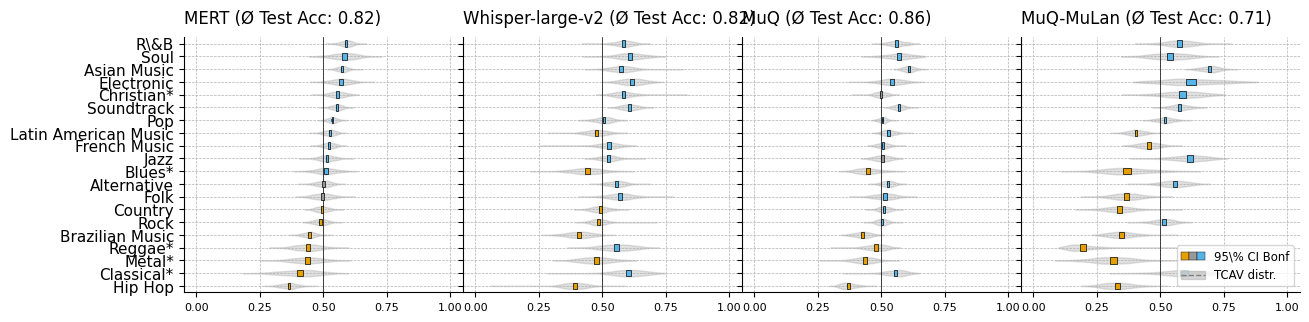

Evaluating gender_male with mert_v1_95m on genre
Evaluating gender_male with whisper_large_v2 on genre
Evaluating gender_male with muq_large_msd on genre
Evaluating gender_male with muq_mulan_large on genre


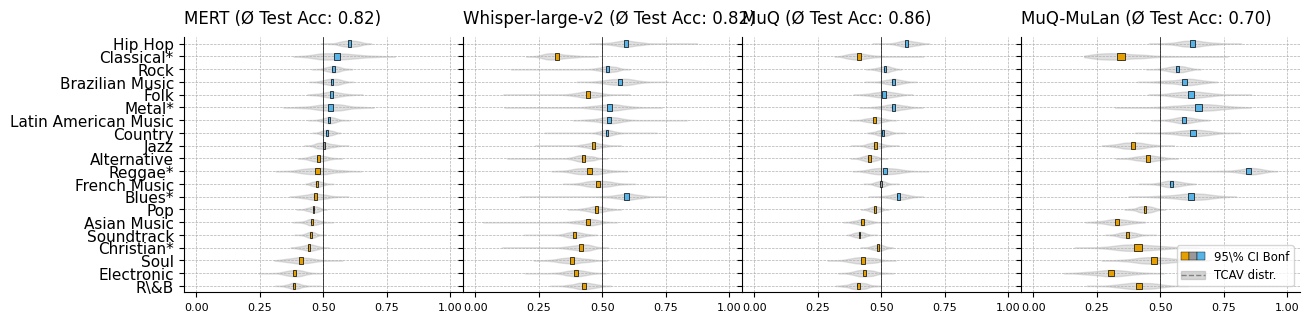

Evaluating language_de with mert_v1_95m on genre


KeyboardInterrupt: 

In [29]:
table_metrics = {}

for project_name in project_names:
    project_metrics = defaultdict(dict)

    for encoder_id in encoder_ids:
        print(f"Evaluating {project_name} with {encoder_id} on {target_column}")

        df_test = load_df_and_embeddings(
            project_name, "test", encoder_id, dataset_prefix, embedding_prefix, s3
        )

        cav_weights_full = get_cav_vectors(project_name, encoder_id, "weight_full")
        cav_weights_ttest = get_cav_vectors(project_name, encoder_id, "weight_ttest")

        cav_biases_full = get_cav_vectors(project_name, encoder_id, "bias_full")
        cav_biases_ttest = get_cav_vectors(project_name, encoder_id, "bias_ttest")

        tcav_scores_full = calculate_tcav_scores(
            cav_weights_full,
            cav_biases_full,
            df_test,
            target_column,
        )

        tcav_scores = calculate_tcav_scores(
            cav_weights_ttest,
            cav_biases_ttest,
            df_test,
            target_column,
        )

        ttest_result = t_test_on_tcav_scores(
            tcav_scores,
            bonferroni_correction_n_tests=n_individual_significance_tests,
            verbose=False,
        )

        project_metrics[encoder_id]["tcav_scores"] = tcav_scores
        project_metrics[encoder_id]["ttest_results"] = ttest_result

        project_metrics[encoder_id]["metrics_ttest"] = get_train_evaluation_metrics(
            project_name, encoder_id, "ttest"
        )
        mean_test_acc = np.mean(
            [x["accuracy"] for x in project_metrics[encoder_id]["metrics_ttest"]]
        )
        project_metrics[encoder_id]["metrics_ttest_mean_acc"] = mean_test_acc
        project_metrics[encoder_id]["tcav_scores_full"] = tcav_scores_full

    file_name = os.path.join(
        "plots",
        f"tcav_ttest_{project_name}_{target_column}.png",
    )

    plot_tcav_scores(
        project_metrics,
        project_name,
        out_file_name=file_name,
    )

    table_metrics[project_name] = project_metrics

### Concept De-biasing


In [7]:
import os

import numpy as np
import pandas as pd
import s3fs
from cavmir.utils import load_df_and_embeddings, train_cav_classifier, get_cav_vectors
from collections import defaultdict
import matplotlib.pyplot as plt

s3 = s3fs.S3FileSystem()

embedding_prefix = os.environ["EMBEDDING_PREFIX"]
dataset_prefix = os.environ["DATASET_PREFIX"]


def equally_sample_from_df(
    df: pd.DataFrame, col: str, val: object, n: int, random_state: int
) -> pd.DataFrame:
    df_positive = df[df[col] == val]
    df_negative = df[df[col] != val]

    df_positive_sample = df_positive.sample(n=n // 2, random_state=random_state)
    df_negative_sample = df_negative.sample(n=n // 2, random_state=random_state)

    return pd.concat([df_positive_sample, df_negative_sample])


#### Train Hip-Hop Classifier


In [8]:
project_name = "genre_hip_hop"
encoder_id = "muq_mulan_large"

epochs = 10000
learning_rate = 0.004
embedding_dim = 512
dropout = 0.0

In [9]:
# remove last folder and replace by "dataset_hip_hop"
dataset_hip_hop_prefix = dataset_prefix.split("/")[:-2]
dataset_hip_hop_prefix.append("dataset_hip_hop")
dataset_hip_hop_prefix = "/".join(dataset_hip_hop_prefix)


In [10]:
train_val_split = 0.9

df = load_df_and_embeddings(
    project_name,
    "train",
    encoder_id,
    dataset_hip_hop_prefix,
    embedding_prefix,
    s3,
)

df_test = load_df_and_embeddings(
    project_name,
    "test",
    encoder_id,
    dataset_hip_hop_prefix,
    embedding_prefix,
    s3,
)

df_test_concept = equally_sample_from_df(
    df[df.genre == "hip_hop"], "gender", "male", 200, 0
)

df = df.drop(df_test_concept.index)
df = df.drop(df[df.genre != "hip_hop"].sample(200, random_state=0).index)

training_size = int(len(df) * train_val_split)
validation_size = int(len(df) - training_size)


Epoch 100/10000
Epoch 100 Train Loss: 0.2778
Epoch 100 Validation Loss: 0.2792
Model saved to trainings/genre_hip_hop/state_dict.pth
Epoch 200/10000
Epoch 200 Train Loss: 0.2265
Epoch 200 Validation Loss: 0.2296
Model saved to trainings/genre_hip_hop/state_dict.pth
Epoch 300/10000
Epoch 300 Train Loss: 0.2107
Epoch 300 Validation Loss: 0.2141
Model saved to trainings/genre_hip_hop/state_dict.pth
Epoch 400/10000
Epoch 400 Train Loss: 0.2031
Epoch 400 Validation Loss: 0.2064
Model saved to trainings/genre_hip_hop/state_dict.pth
Epoch 500/10000
Epoch 500 Train Loss: 0.1985
Epoch 500 Validation Loss: 0.2015
Model saved to trainings/genre_hip_hop/state_dict.pth
Epoch 600/10000
Epoch 600 Train Loss: 0.1952
Epoch 600 Validation Loss: 0.1979
Model saved to trainings/genre_hip_hop/state_dict.pth
Epoch 700/10000
Epoch 700 Train Loss: 0.1926
Epoch 700 Validation Loss: 0.1950
Model saved to trainings/genre_hip_hop/state_dict.pth
Epoch 800/10000
Epoch 800 Train Loss: 0.1905
Epoch 800 Validation Los

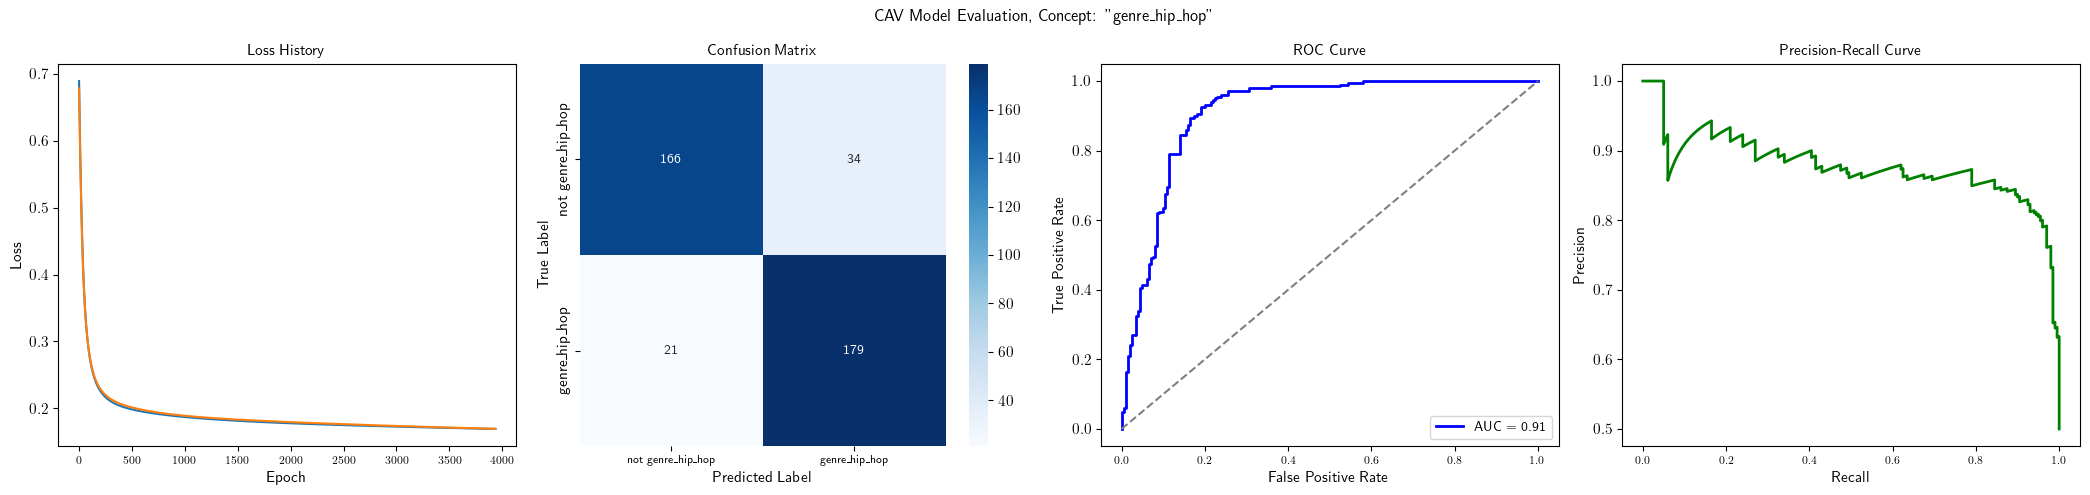

In [11]:
cav_weight, cav_bias, metrics = train_cav_classifier(
    random_state=0,
    df=df,
    df_test=df_test,
    project_name=project_name,
    training_sample_size=training_size,
    validation_sample_size=validation_size,
    embedding_dim=embedding_dim,
    epochs=epochs,
    learning_rate=learning_rate,
    dropout_rate=dropout,
    plot_evaluation=True,
    verbose_steps=100,
)

#### Mix Hip Hop CAV with gender CAVs


In [12]:
def track_activations_by_cav_vector(target_embeddings, cav_weight, cav_bias):
    return (target_embeddings @ cav_weight.T) + cav_bias


def male_in_top_100(target_activations):
    return sum(np.argsort(target_activations[:, 0])[::-1][:100] < 100) / 100


def morph_weights(cav_weight, mix_in_cav_weight, lambda_):
    return (1 - lambda_) * cav_weight + lambda_ * mix_in_cav_weight


In [13]:
cav_weight_male = get_cav_vectors("gender_male", encoder_id, "weight_full")
cav_weight_female = get_cav_vectors("gender_female", encoder_id, "weight_full")

target_embeddings = np.array([np.array(x) for x in df_test_concept.embedding.values])


In [14]:
lambdas = []
male_in_top_100s = defaultdict(list)

for _lambda in np.linspace(0, 1, 101):
    lambdas.append(_lambda)

    #### Subtract Male ####

    new_cav_weight = morph_weights(cav_weight, -cav_weight_male, _lambda)
    target_activations = target_embeddings @ new_cav_weight.T
    male_in_top_100s["male"].append(male_in_top_100(target_activations))

    #### Add Female ####

    new_cav_weight = morph_weights(cav_weight, cav_weight_female, _lambda)
    target_activations = target_embeddings @ new_cav_weight.T
    male_in_top_100s["female"].append(male_in_top_100(target_activations))


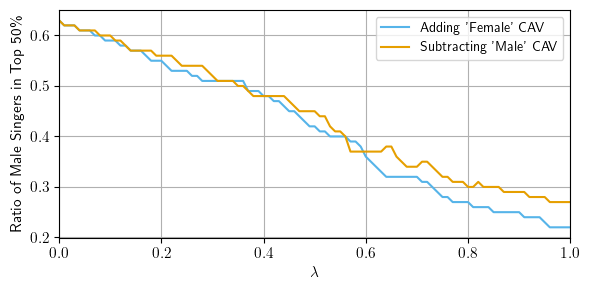

In [15]:
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["FreeSans"],
        "font.serif": ["FreeSerif"],
        "axes.titlesize": 11,
        "axes.labelsize": 11,
        "xtick.labelsize": 11,
        "ytick.labelsize": 11,
        "legend.fontsize": 10,
        "text.usetex": True,
    }
)

plt.figure(figsize=(6, 3))


plt.plot(
    lambdas, male_in_top_100s["female"], color="#56B4E9", label="Adding 'Female' CAV"
)
plt.plot(
    lambdas, male_in_top_100s["male"], color="#E69F00", label="Subtracting 'Male' CAV"
)

plt.xlabel(r"$\lambda$")
plt.ylabel("Ratio of Male Singers in Top 50\\%")
plt.legend(loc="upper right")

plt.xlim([0, 1])
plt.grid()

# save to file
plt.tight_layout()
plt.savefig("plots/hip_hop_debiasing.png", dpi=300)

plt.show()